# COMUNICACION DE RESULTADOS

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

pd.options.display.max_columns = None

con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df_preparado', con = con)

#Minicubo:

metricas = ['precio_total','precio_compra']
dimensiones = ['bedrooms_disc','accommodates_disc','beds_disc','number_of_reviews_disc']

minicubo_precio = df[dimensiones + metricas]

minicubo_precio = minicubo_precio.melt(id_vars=['precio_total','precio_compra'])

minicubo_precio = minicubo_precio.groupby(['variable','value'])[['precio_total','precio_compra']].agg('median')

In [2]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df_preparado', con = con)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17710 entries, 0 to 17709
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   level_0                         17710 non-null  int64  
 1   index                           17710 non-null  int64  
 2   id                              17710 non-null  int64  
 3   name                            17707 non-null  object 
 4   host_id                         17710 non-null  int64  
 5   neighbourhood_group             17710 non-null  object 
 6   neighbourhood                   17710 non-null  object 
 7   latitude                        17710 non-null  float64
 8   longitude                       17710 non-null  float64
 9   room_type                       17710 non-null  object 
 10  price                           17710 non-null  int64  
 11  minimum_nights                  17710 non-null  int64  
 12  calculated_host_listings_count  

## CONTEXTO DEL ANALISIS

Buscar inmuebles en los que invertir con el objetivo de obtener rentabilidad mediante alquiler turístico.

Para ello, se realia un análisis de Discovery que permita identificar estrategias o líneas de trabajo que ayuden a dirigir la actuación en posibles inversiones.

## OBJETIVOS

* Analizar las fuentes de datos públicas disponibles
* Para encontrar insights que ayuden a entender las características del mercado en esta ciudad
* Especialmente en cuanto a los principales ejes: precio del alquiler, niveles de ocupación y precio de compra

## CONCLUSIONES EJECUTIVAS

* Se han localizado 10 barrios en los que centrar la búsqueda
* Se recomienda buscar inmuebles con un habitación que permitan alojar 3 huéspedes
* Se recomienda buscar inmuebles que estando en uno de los barrios identificados no estén necesariamente cerca de puntos de interés
* Se recomienda evaluar el desarrollo de un nuevo producto basado en el alquier para momentos concretos de alto interés deportivo, especialmente en el barrio de San Blas

## DETALLE DE LOS PRINCIPALES RESULTADOS

### Existen 10 barrios con alto potencial de inversión

* Se han localizado 10 barrios que apriori pueden maximizar la relación coste-ingresos
* Además podemos segmentarlos por el tipo calidad del inmueble en el que nos interes invertir en 4 grandes grupos
* Estos son los 10 barrios donde comenzar a buscar oportunidades concretas:
    * Inversión baja: Simancas, Ambroz, Marroquina, San Juan Bautista
    * Inversión media: El Plantio, Valdemarín, Valdefuentes
    * Inversión media-alta: Jerónimos, Fuentela reina
    * Inversión alta: Recoletos

Exhibit 1.4.1

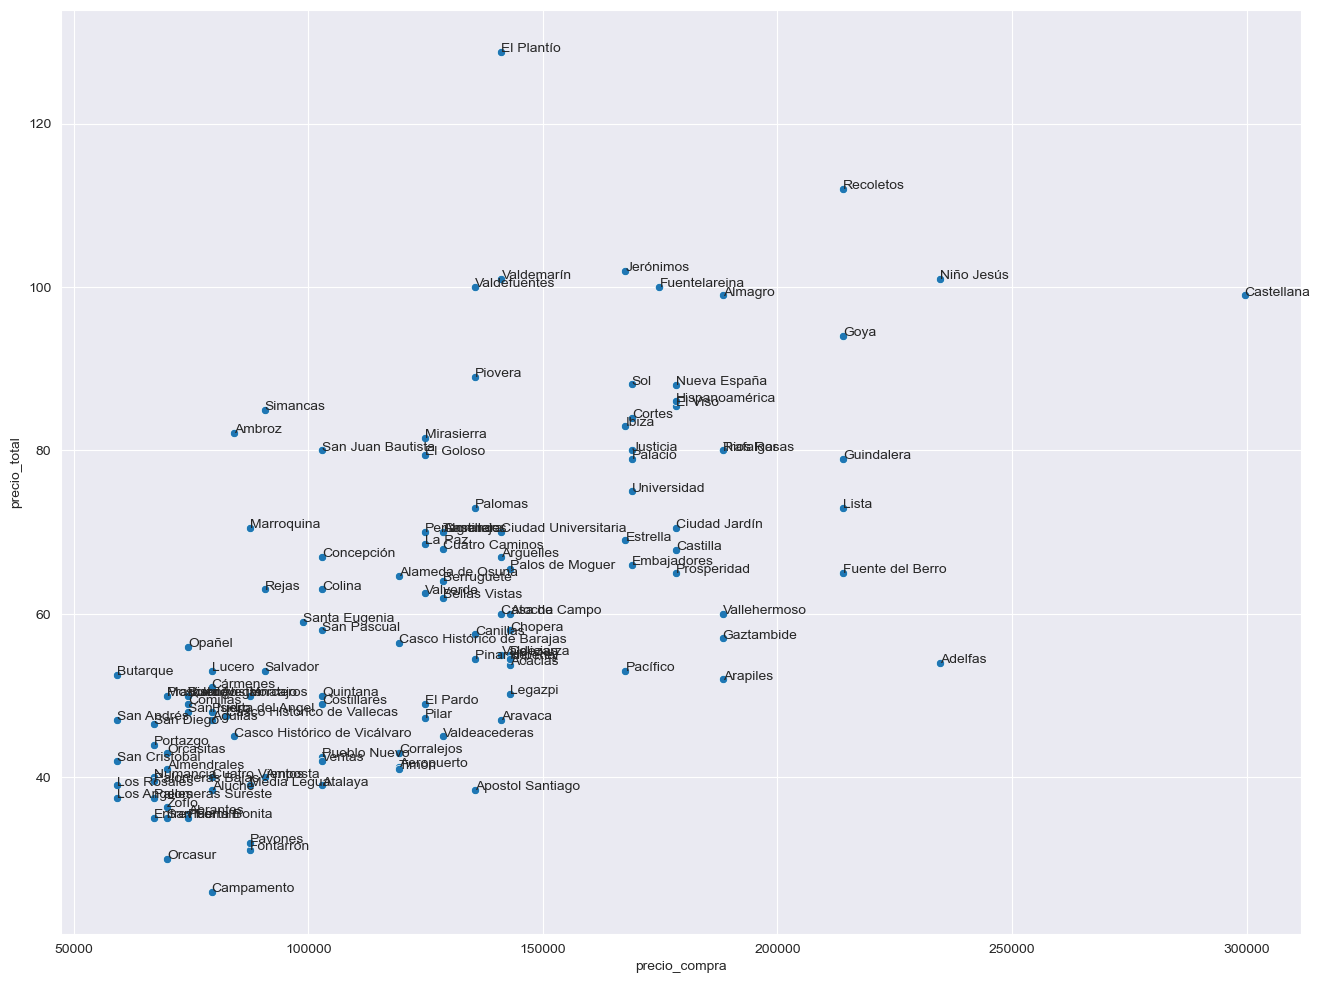

In [4]:
no_incluir = ['Rosas','Arcos','Canillejas','Hellín']

temp = df.groupby('neighbourhood')[['precio_total','precio_compra']].median()

temp = temp[~temp.index.isin(no_incluir)]

plt.figure(figsize = (16,12))
sns.set_style('darkgrid')
sns.scatterplot(data = temp, x = 'precio_compra', y = 'precio_total')
#Ponemos las etiquetas
for cada in range(0,temp.shape[0]):
    plt.text(temp.precio_compra.iloc[cada], temp.precio_total.iloc[cada], temp.index[cada])

### Buscar inmuebles de una habitación que permitan 3 huéspedes

* El número de huéspedes que maximiza el precio de compra pagado es de 3

Exhibit 1.4.2

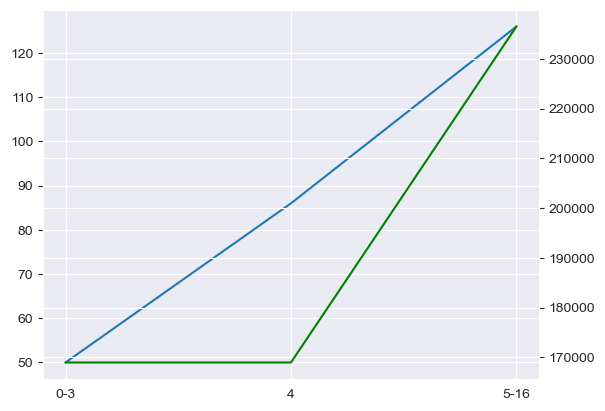

In [5]:
f, ax = plt.subplots()
ax.plot(minicubo_precio.loc['accommodates_disc'].precio_total)
ax2 = ax.twinx()
ax2.plot(minicubo_precio.loc['accommodates_disc'].precio_compra,color = 'green');

### Buscar inmuebles que estando en uno de los barrios identificados no estén necesariamente cerca de puntos de interés

* Previsiblemente tendrán menor precio de compra
* Parece que la cercanía a puntos de interés no tiene un especial impacto sobre el precio del alquiler

Exhibit 1.4.3

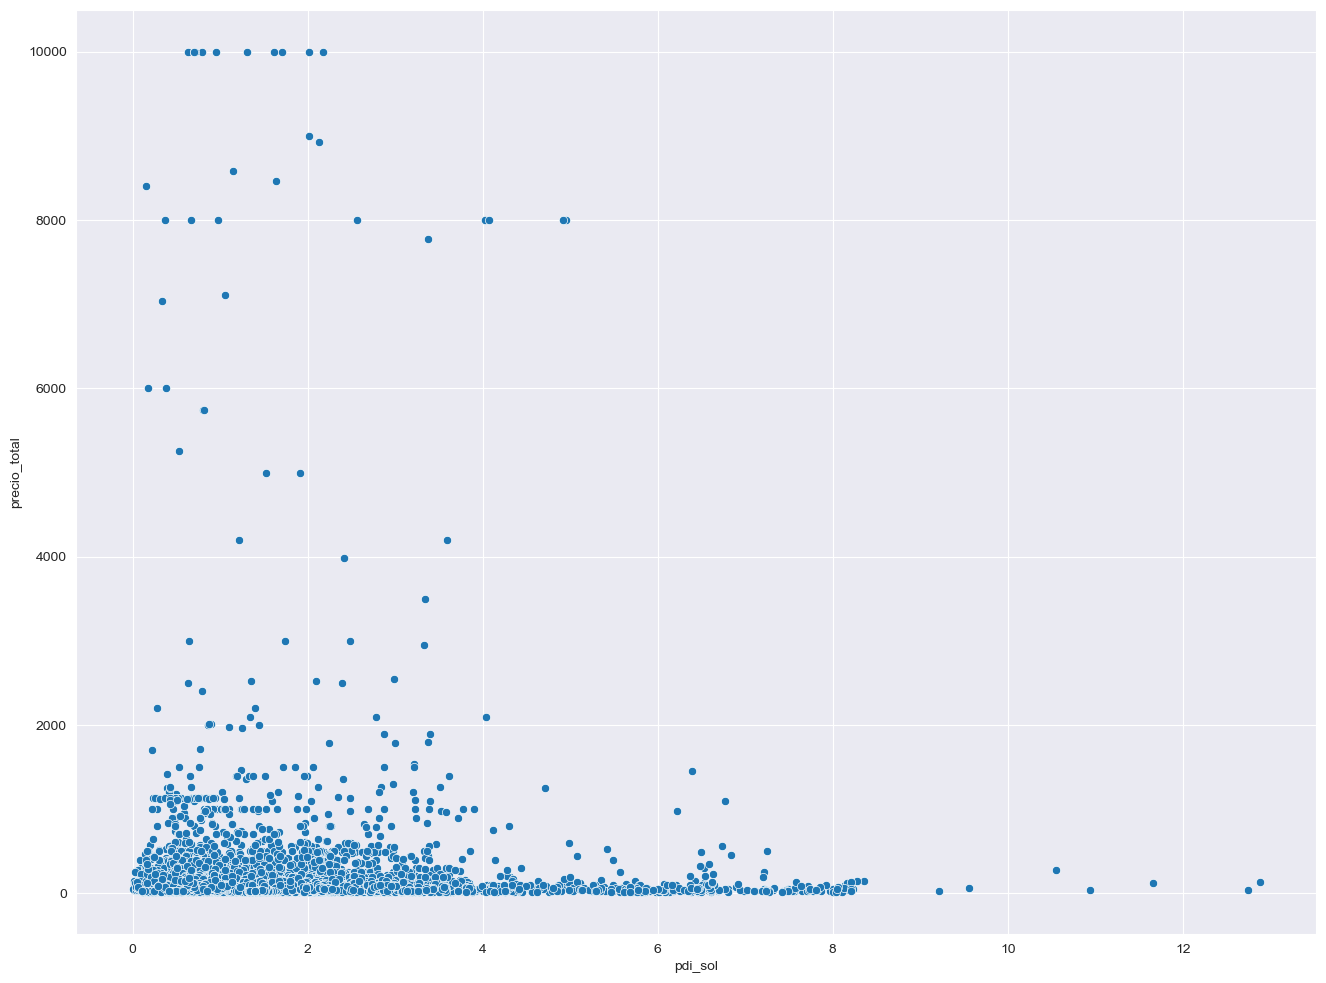

In [6]:
seleccion = df.groupby('distrito').pdi_sol.median().sort_values()[0:7].index.to_list()

plt.figure(figsize = (16,12))
sns.scatterplot(data = df.loc[df.distrito.isin(seleccion)], x = 'pdi_sol', y = 'precio_total');

### Evaluar el desarrollo de un nuevo producto basado en el alquier para momentos concretos de alto interés deportivo

* Buscar oportunidades en el barrio de San Blas
* Todavía existen muchos alquileres que no están explotando este potencial

Exhibit 1.4.4

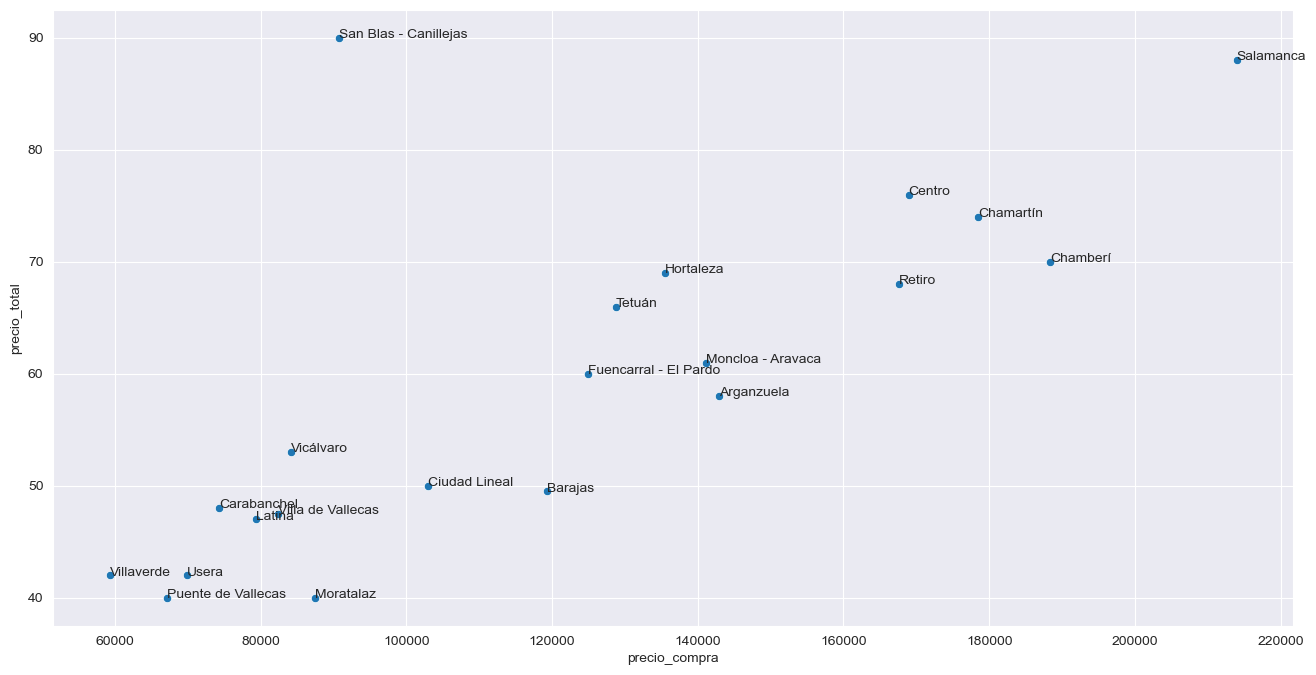

In [7]:
temp = df.groupby('distrito')[['precio_total','precio_compra']].median()

plt.figure(figsize = (16,8))
sns.scatterplot(data = temp, x = 'precio_compra', y = 'precio_total')
#Ponemos las etiquetas
for cada in range(0,temp.shape[0]):
    plt.text(temp.precio_compra.iloc[cada], temp.precio_total.iloc[cada], temp.index[cada])

Exhibit 1.4.5

In [8]:
import folium

datos = df[df.distrito == 'San Blas - Canillejas'].copy()

datos['precio_total_disc'] = pd.qcut(datos['precio_total'], q = [0, .25, .5, .75, 1.], 
                              labels=['yellow', 'orange', 'blue', 'red'])

mapa = folium.Map(location=[datos.iloc[0,7], datos.iloc[0,8]],zoom_start=14)

for piso in range(0,len(datos)):
   folium.CircleMarker(
      location = [datos.iloc[piso]['latitude'], datos.iloc[piso]['longitude']],
      popup = datos.iloc[piso]['precio_total'],
      fill=True,
      color = datos.iloc[piso]['precio_total_disc'],
      fill_opacity=1,
      radius = 5
   ).add_to(mapa)

mapa